<a href="https://colab.research.google.com/github/cgenevier/CSCI5622-HW4/blob/part-c-estimation-using-acoustic-features/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Study 1: Designing explainable speech-based machine learning models of depression

To open this ipynb in Colab, click the "Open in Colab" button at the top of the ipynb in Github, or [follow this link](https://colab.research.google.com/github/cgenevier/CSCI5622-HW4/blob/main/main.ipynb).

Given that Colab doesn't automatically load any of the content (data or other functions) from the Github repo, running the code below will copy the repo into the workspace directory for use. To save this ipynb file back to Github, select **File > Save** (which should show the repo if you're signed in) or **File > Save a copy in Github** if it's in the menu.

Note that the content of the data files or any of the other file structures are not saved back to Github, so make sure that if you make changes to things there, that you put them in Github separately.

In [1]:
# Clone Github Repo into the temporary local environment so data can be accessed and manipulated
!git clone https://github.com/cgenevier/CSCI5622-HW4.git
%cd CSCI5622-HW4

fatal: destination path 'CSCI5622-HW4' already exists and is not an empty directory.
/content/CSCI5622-HW4


In [2]:
# Import necessary libraries

# Helpers
import glob

# Pandas, seaborn, and numpy for data manipulation
import pandas as pd
pd.set_option("display.max_rows", None)
import statistics as stat
import seaborn as sns
import numpy as np
np.random.seed(42)

# Keras & TensorFlow for building the neural networks
import itertools, json, time
from itertools import count
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, callbacks, backend as K
tf.random.set_seed(42)

# Feature extraction
!pip install vaderSentiment transformers torch
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import logging, BertTokenizer, BertModel
import torch

# Matplotlib for graphing
import matplotlib.pyplot as plt

# Disable progress bars (necessary for it to show up correctly in Github)
logging.set_verbosity_error()

##### Formatting the data - Depression Labels

In [3]:
# Import Depression Labels
# Columns: Participant_ID, PHQ_Score
depression_labels = pd.read_csv("data/DepressionLabels.csv")

# Rename Participant_ID to ParticipantID to match accoustic files below & force trimmed string type
depression_labels = depression_labels.rename(columns={"Participant_ID": "ParticipantID"})
depression_labels["ParticipantID"] = depression_labels["ParticipantID"].astype(str).str.strip()

##### Formatting the data - Text Features

In [4]:
# Import Text Dataset (for text feature extraction)
# Note: When comparing the E-DAIC_Transcripts files to the corresponding E-DAIC Acoustics files,
# it looks like the transcripts sometimes only contain partial data from the accoustics text column -
# for example, 386_Transcript.csv - so it seems to make sense to concatenate Text data in the
# Acoustics file for completeness.
rows = []
for p in glob.glob("data/E-DAIC_Acoustics/*_utterance_agg.csv"):
    df = pd.read_csv(p)
    df["ParticipantID"] = df["ParticipantID"].astype(str).str.strip()
    full_text = " ".join(df["Text"].dropna().astype(str))
    full_text = " ".join(full_text.split())  # collapse whitespace
    rows.append({"ParticipantID": df["ParticipantID"].iloc[0], "FullText": full_text})

# Columns: ParticipantID, FullText
text_df = pd.DataFrame(rows)
# Merge with labels. Columns: ParticipantID, FullText, PHQ_Score
lang_df = depression_labels.merge(text_df, on="ParticipantID", how="inner")

# Inspect results
lang_df.head()

,ParticipantID,PHQ_Score,FullText
0,386,11,might have pulled something that I'm going to ...
1,387,2,when she's done she'll let you know alrighty t...
2,388,17,are you okay with yes doing all right from Pas...
3,389,14,and please are you okay sure I'm okay small to...
4,390,9,and now she's going to chat with you for a bit...


##### Formatting the data - Acoustic Features

In [5]:
# Import Accoustic Dataset (for part c, d)

# Helper function for mean, standard dev, & IQR (interquartile range)
def summarize_cols(num_df: pd.DataFrame) -> pd.DataFrame:
    # mean and std per column (NaN-safe)
    mean_s = num_df.mean(numeric_only=True)
    std_s  = num_df.std(numeric_only=True)
    # IQR = Q3 - Q1 per column
    q75 = num_df.quantile(0.75, numeric_only=True)
    q25 = num_df.quantile(0.25, numeric_only=True)
    iqr_s = q75 - q25

    # assemble into a tidy (feature, stat) table
    stats = pd.concat(
        {"mean": mean_s, "std": std_s, "iqr": iqr_s},
        axis=1
    )  # index=feature, columns=[mean,std,iqr]

    # flatten to one row with columns like feature__mean
    wide = stats.stack().to_frame().T
    wide.columns = [f"{feat}__{stat}" for feat, stat in wide.columns]
    return wide

# Each file in E-DAIC_Acoustics contains utterance-level acoustic features for one participant.
rows_with_conf = []
rows_no_conf = []
for p in glob.glob("data/E-DAIC_Acoustics/*_utterance_agg.csv"):
    df = pd.read_csv(p)
    df["ParticipantID"] = df["ParticipantID"].astype(str).str.strip()

    # Include Confidence (column 5) + all acoustic features (6+)
    numeric_with_conf = df.columns[5:]
    df[numeric_with_conf] = df[numeric_with_conf].apply(pd.to_numeric, errors="coerce")

    agg_with_conf = summarize_cols(df[numeric_with_conf])
    agg_with_conf.insert(0, "ParticipantID", df["ParticipantID"].iloc[0])
    rows_with_conf.append(agg_with_conf)

    # Excludes Confidence - only include acoustic features
    numeric_no_conf = df.columns[6:]
    df[numeric_no_conf] = df[numeric_no_conf].apply(pd.to_numeric, errors="coerce")

    agg_no_conf = summarize_cols(df[numeric_no_conf])
    agg_no_conf.insert(0, "ParticipantID", df["ParticipantID"].iloc[0])
    rows_no_conf.append(agg_no_conf)

# Combine into one DataFrame each
acoustic_features_with_conf = pd.concat(rows_with_conf, ignore_index=True)
acoustic_features_no_conf = pd.concat(rows_no_conf, ignore_index=True)

# Merge with labels to add PHQ_Score
acoustic_df_with_confidence = depression_labels.merge(acoustic_features_with_conf, on="ParticipantID", how="inner")
acoustic_df_no_confidence   = depression_labels.merge(acoustic_features_no_conf, on="ParticipantID", how="inner")

# Reorder columns: ParticipantID, PHQ_Score, then features
cols = ["ParticipantID", "PHQ_Score"] + [c for c in acoustic_df_with_confidence.columns if c not in ["ParticipantID", "PHQ_Score"]]
acoustic_df_with_confidence = acoustic_df_with_confidence[cols]
cols = ["ParticipantID", "PHQ_Score"] + [c for c in acoustic_df_no_confidence.columns if c not in ["ParticipantID", "PHQ_Score"]]
acoustic_df_no_confidence = acoustic_df_no_confidence[cols]

# Inspect results
display(acoustic_df_with_confidence.head())
display(acoustic_df_no_confidence.head())

,ParticipantID,PHQ_Score,Confidence__mean,Confidence__std,Confidence__iqr,Loudness_sma3__mean,Loudness_sma3__std,Loudness_sma3__iqr,alphaRatio_sma3__mean,alphaRatio_sma3__std,...,F2frequency_sma3nz__iqr,F2amplitudeLogRelF0_sma3nz__mean,F2amplitudeLogRelF0_sma3nz__std,F2amplitudeLogRelF0_sma3nz__iqr,F3frequency_sma3nz__mean,F3frequency_sma3nz__std,F3frequency_sma3nz__iqr,F3amplitudeLogRelF0_sma3nz__mean,F3amplitudeLogRelF0_sma3nz__std,F3amplitudeLogRelF0_sma3nz__iqr
0,386,11,0.933917,0.055195,0.037800,0.147390,0.064438,0.089581,-15.719342,2.713920,...,42.335639,-128.087978,39.510693,63.620488,2584.433064,57.013353,47.965921,-131.009492,37.808278,59.861069
1,387,2,0.931755,0.062020,0.064689,0.094281,0.061988,0.060425,-17.290294,2.972634,...,117.523721,-140.359126,45.511084,86.525518,2525.715990,84.201997,76.811123,-142.535582,43.594940,82.822549
2,388,17,0.888103,0.105329,0.123520,0.103571,0.045205,0.069353,-16.480069,2.705549,...,81.395833,-156.991100,32.353199,56.016943,2549.702244,75.558349,94.163420,-158.777582,30.838568,53.547303
3,389,14,0.897373,0.099174,0.103688,0.095695,0.038370,0.055492,-20.799213,2.820568,...,81.503827,-143.443426,33.056194,47.504207,2549.110120,70.157241,97.720753,-145.861499,31.530769,45.670156
4,390,9,0.900761,0.082217,0.088130,0.106446,0.045064,0.052923,-17.288813,2.328784,...,79.791693,-139.494192,31.536717,39.076320,2450.182795,73.798789,106.373400,-142.697953,29.870122,36.615301


,ParticipantID,PHQ_Score,Loudness_sma3__mean,Loudness_sma3__std,Loudness_sma3__iqr,alphaRatio_sma3__mean,alphaRatio_sma3__std,alphaRatio_sma3__iqr,hammarbergIndex_sma3__mean,hammarbergIndex_sma3__std,...,F2frequency_sma3nz__iqr,F2amplitudeLogRelF0_sma3nz__mean,F2amplitudeLogRelF0_sma3nz__std,F2amplitudeLogRelF0_sma3nz__iqr,F3frequency_sma3nz__mean,F3frequency_sma3nz__std,F3frequency_sma3nz__iqr,F3amplitudeLogRelF0_sma3nz__mean,F3amplitudeLogRelF0_sma3nz__std,F3amplitudeLogRelF0_sma3nz__iqr
0,386,11,0.147390,0.064438,0.089581,-15.719342,2.713920,3.345443,26.607891,2.620843,...,42.335639,-128.087978,39.510693,63.620488,2584.433064,57.013353,47.965921,-131.009492,37.808278,59.861069
1,387,2,0.094281,0.061988,0.060425,-17.290294,2.972634,3.860120,27.380149,3.369106,...,117.523721,-140.359126,45.511084,86.525518,2525.715990,84.201997,76.811123,-142.535582,43.594940,82.822549
2,388,17,0.103571,0.045205,0.069353,-16.480069,2.705549,3.389694,26.983015,3.081380,...,81.395833,-156.991100,32.353199,56.016943,2549.702244,75.558349,94.163420,-158.777582,30.838568,53.547303
3,389,14,0.095695,0.038370,0.055492,-20.799213,2.820568,3.971909,31.428066,3.209966,...,81.503827,-143.443426,33.056194,47.504207,2549.110120,70.157241,97.720753,-145.861499,31.530769,45.670156
4,390,9,0.106446,0.045064,0.052923,-17.288813,2.328784,2.859256,29.355163,3.087194,...,79.791693,-139.494192,31.536717,39.076320,2450.182795,73.798789,106.373400,-142.697953,29.870122,36.615301


### (a) (2 points) Extracting language features.

**Syntactic vectorizers:** count vectorizer (e.g., CountVectorizer from sklearn) transforming
a collection of text documents into a numerical matrix of word or token counts; TFIDF vectorizer (e.g., TfidfVectorizer from sklearn) incorporating document-level weighting,
which emphasizes words significant to specific documents’ part-of-speech features counting
the distribution of part of speech tags over a document

In [6]:
# Use TfidfVectorizer from sklearn
vect = TfidfVectorizer(max_features=1000)
X_tfidf = vect.fit_transform(lang_df["FullText"])

# Convert sparse matrix to DataFrame
syntactic_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vect.get_feature_names_out()
)

# Add ParticipantID column & move to first column
syntactic_df["ParticipantID"] = lang_df["ParticipantID"].values
cols = ["ParticipantID"] + [c for c in syntactic_df.columns if c != "ParticipantID"]
syntactic_df = syntactic_df[cols]

# Add back in PHQ_Score & move to second column
syntactic_df = syntactic_df.merge(depression_labels, on="ParticipantID", how="inner")
cols = ["ParticipantID", "PHQ_Score"] + [c for c in syntactic_df.columns if c not in ["ParticipantID", "PHQ_Score"]]
syntactic_df = syntactic_df[cols]

# Inspect dataframe
syntactic_df.head()

,ParticipantID,PHQ_Score,10,12,15,16,18,19,20,30,...,years,yes,yesterday,yet,york,you,young,younger,your,yourself
0,386,11,0.008629,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.017304,0.010626,0.000000,0.000000,0.000000,0.352579,0.011235,0.0,0.016919,0.019328
1,387,2,0.027755,0.000000,0.0,0.0,0.0,0.0,0.032038,0.0,...,0.074209,0.000000,0.000000,0.000000,0.047486,0.346512,0.072275,0.0,0.108838,0.031083
2,388,17,0.031186,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.041692,0.038404,0.000000,0.040133,0.000000,0.283166,0.000000,0.0,0.020382,0.034926
3,389,14,0.054573,0.052964,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.036479,0.000000,0.000000,0.000000,0.000000,0.325182,0.000000,0.0,0.089168,0.000000
4,390,9,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016775,0.0,...,0.067999,0.008948,0.020119,0.000000,0.000000,0.123706,0.000000,0.0,0.009498,0.016275


**Semantic features:** sentiment scores (e.g., Vader, https://github.com/cjhutto/vaderSentiment),
topic distribution (using topic modeling), or named entities

In [7]:
# Using Vader to analyze sentiment of the text data
analyzer = SentimentIntensityAnalyzer()

# Apply Vader to the text data (creates 4 new columns)
vader_scores = lang_df["FullText"].apply(lambda x: pd.Series(analyzer.polarity_scores(str(x))))
semantic_df = pd.concat([lang_df, vader_scores], axis=1)

# Inspect dataframe
semantic_df.head()


,ParticipantID,PHQ_Score,FullText,neg,neu,pos,compound
0,386,11,might have pulled something that I'm going to ...,0.046,0.770,0.184,0.9999
1,387,2,when she's done she'll let you know alrighty t...,0.050,0.665,0.285,0.9996
2,388,17,are you okay with yes doing all right from Pas...,0.070,0.769,0.161,0.9953
3,389,14,and please are you okay sure I'm okay small to...,0.057,0.827,0.116,0.9822
4,390,9,and now she's going to chat with you for a bit...,0.067,0.740,0.193,0.9996


**Advanced features:** word embeddings, such as Word2Vec or BERT (e.g., pytorch-pretrainedbert)) for capturing contextual meaning

In [8]:
# Use BERT to capture contextual meaning (note: takes about 4 minutes to run on T4)

# Load uncased base model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Loop through text data and get embeddings
embeddings = []
for text in lang_df["FullText"]:
    # Truncate long text (BERT max = 512 tokens)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # [CLS] token
    embeddings.append(cls_embedding)

# Convert list of embeddings (each 768-dim) to DataFrame
bert_df = pd.DataFrame(np.vstack(embeddings))
bert_df.columns = [f"bert_{i}" for i in range(bert_df.shape[1])]

# Add ParticipantID and PHQ_Score
bert_df = pd.concat([lang_df[["ParticipantID", "PHQ_Score"]].reset_index(drop=True), bert_df], axis=1)

# Inspect dataframe
bert_df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,ParticipantID,PHQ_Score,bert_0,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,...,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767
0,386,11,0.024454,0.250101,0.480640,-0.209235,-0.064230,-0.409601,0.119545,0.926130,...,0.003123,-0.820313,-0.263505,-0.272017,0.424426,0.617825,-0.222068,-0.407772,0.242542,-0.204929
1,387,2,-0.085553,-0.097101,0.228180,0.072628,-0.162793,-0.457378,-0.005894,0.718334,...,0.354261,-1.054273,-0.246188,-0.318969,0.135777,0.865151,-0.351662,-0.323795,0.236854,-0.311686
2,388,17,-0.077363,0.149377,0.376863,0.118528,-0.100990,-0.355886,0.216298,0.758371,...,0.062572,-0.927725,-0.235412,-0.189596,0.669311,0.589867,-0.421785,-0.244375,0.100614,-0.064971
3,389,14,-0.305623,0.097801,0.182487,0.152354,-0.197408,-0.229550,0.315507,0.775767,...,0.160983,-1.146030,-0.109301,-0.369335,0.432705,0.457361,-0.329305,-0.434079,0.119847,-0.388671
4,390,9,-0.075243,-0.034517,0.310655,0.051466,-0.144260,-0.145557,0.093521,0.791168,...,-0.124968,-0.980401,-0.147667,-0.188620,0.437721,0.501310,-0.376553,-0.422697,0.162246,-0.142558


**Combined dataset:** Combined the three dataframes above into one with all the features

In [9]:
# Merge all three on ParticipantID
text_feature_df = (
    syntactic_df
    .merge(semantic_df, on=["ParticipantID", "PHQ_Score"], how="outer")
    .merge(bert_df, on=["ParticipantID", "PHQ_Score"], how="outer")
)
text_feature_df.head()

# Optional: sort by ParticipantID for clarity
#merged_df = merged_df.sort_values("ParticipantID").reset_index(drop=True)

,ParticipantID,PHQ_Score,10,12,15,16,18,19,20,30,...,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767
0,386,11,0.008629,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.003123,-0.820313,-0.263505,-0.272017,0.424426,0.617825,-0.222068,-0.407772,0.242542,-0.204929
1,387,2,0.027755,0.000000,0.0,0.0,0.0,0.0,0.032038,0.0,...,0.354261,-1.054273,-0.246188,-0.318969,0.135777,0.865151,-0.351662,-0.323795,0.236854,-0.311686
2,388,17,0.031186,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.062572,-0.927725,-0.235412,-0.189596,0.669311,0.589867,-0.421785,-0.244375,0.100614,-0.064971
3,389,14,0.054573,0.052964,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.160983,-1.146030,-0.109301,-0.369335,0.432705,0.457361,-0.329305,-0.434079,0.119847,-0.388671
4,390,9,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016775,0.0,...,-0.124968,-0.980401,-0.147667,-0.188620,0.437721,0.501310,-0.376553,-0.422697,0.162246,-0.142558


### (b) (2 points) Estimating depression severity with interpretable models using language features.

Question: In semantic feature extraction above, there are four features generated: neg, neu, pos, compound. They are inter-related because neg is the proportion of the document that is negative, neu is the proportion of the document that is neutral, pos is the proportion of the document that is positive, and compound is a normalized sentiment value that takes into account all 3. Should we remove some of these features because they're redundant?

### (c) (2 points) Estimating depression severity with interpretable models using acoustic features.

Dataset shape: (134, 71)
Number of participants: 134
PHQ-8 Score range: 0 to 22
Number of acoustic features: 69

First 10 feature names: ['Loudness_sma3__mean', 'Loudness_sma3__std', 'Loudness_sma3__iqr', 'alphaRatio_sma3__mean', 'alphaRatio_sma3__std', 'alphaRatio_sma3__iqr', 'hammarbergIndex_sma3__mean', 'hammarbergIndex_sma3__std', 'hammarbergIndex_sma3__iqr', 'slope0-500_sma3__mean']

Running Decision Tree evaluation with acoustic features
Starting iteration 1/6: max_depth=3
Evaluating Decision Tree with max_depth=3
  Avg Pearson Correlation: -0.0614
  Avg Relative Error: 0.2216
  Avg MSE: 46.3392
Starting iteration 2/6: max_depth=5
Evaluating Decision Tree with max_depth=5
  Avg Pearson Correlation: -0.0248
  Avg Relative Error: 0.2260
  Avg MSE: 56.5454
Starting iteration 3/6: max_depth=7
Evaluating Decision Tree with max_depth=7
  Avg Pearson Correlation: -0.0799
  Avg Relative Error: 0.2650
  Avg MSE: 70.8424
Starting iteration 4/6: max_depth=10
Evaluating Decision Tree with ma

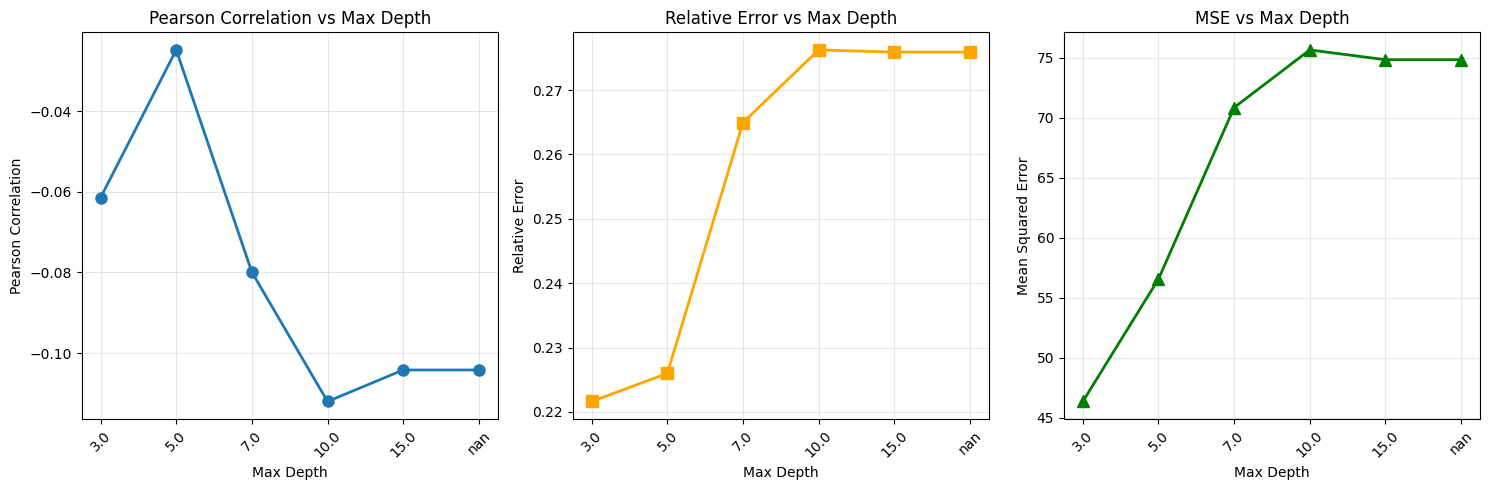

FEATURE IMPORTANCE ANALYSIS

Top acoustic features for depression (max_depth=3):
**************************************************
F1amplitudeLogRelF0_sma3nz__mean: 0.2379 - Fundamental frequency (pitch) - related to vocal pitch variations. Depression may show reduced pitch variability.
F3frequency_sma3nz__std: 0.2203 - Third formant frequency - related to speech resonance. Depression may affect speech resonance.
slope0-500_sma3__mean: 0.2052 - Spectral slope - related to voice spectral characteristics. Spectral changes may reflect emotional state.
F3frequency_sma3nz__mean: 0.1794 - Third formant frequency - related to speech resonance. Depression may affect speech resonance.
mfcc3_sma3__mean: 0.0788 - Mean value. Depression may show overall reduction in acoustic measures.
F1bandwidth_sma3nz__mean: 0.0712 - First formant frequency - related to vowel articulation. Depression may affect vowel space and articulation.
logRelF0-H1-A3_sma3nz__iqr: 0.0072 - Fundamental frequency (pitch) - re

In [10]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr


# calculate absolute relative error
# Parameters:
  # y_true: true PHQ-8 scores
  # y_pred: predicted PHQ-8 scores
  # max_phq: maximum possible PHQ-8 score (default 24)
# Returns:
  # re: float, absolute relative error
def absolute_relative_error(y_true, y_pred, max_phq=24):
  return np.abs(y_true - y_pred) / max_phq

# evaluate decision tree regression using acoustic features with k-fold cross validation
# Parameters:
  # acoustic_data: DataFrame containing acoustic features and PHQ_Score
  # max_depth_values: list of max_depth values to experiment with
  # n_splits: number of folds for cross-validation
# Returns:
  # results: DataFrame with evaluation results for different max_depth values
  # feature_importance: DataFrame showing feature importance from the models
def evaluate_acoustic_decision_tree(acoustic_data, max_depth_values=[3, 5, 7, 10, None], n_splits=5):
  feature_columns = [col for col in acoustic_data.columns if col not in ["ParticipantID", "PHQ_Score"]]

  X = acoustic_data[feature_columns].values
  y = acoustic_data["PHQ_Score"].values

  # k-fold cross-validation
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  # store results for each max_depth
  results = []
  feature_importance_summary = []

  for i, max_depth in enumerate(max_depth_values):
      print(f"Starting iteration {i+1}/{len(max_depth_values)}: max_depth={max_depth}")
      print(f"Evaluating Decision Tree with max_depth={max_depth}")

      # lists to store fold results
      fold_correlations = []
      fold_relative_errors = []
      fold_mse = []

      # perform k-fold cross-validation
      for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
          # split data
          X_train, X_test = X[train_idx], X[test_idx]
          y_train, y_test = y[train_idx], y[test_idx]

          # initialize and train decision tree
          dt = DecisionTreeRegressor(
              max_depth=max_depth,
              random_state=42
          )
          dt.fit(X_train, y_train)

          # make predictions
          y_pred = dt.predict(X_test)

          # calculate evaluation metrics
          correlation, _ = pearsonr(y_test, y_pred)
          relative_error = np.mean(absolute_relative_error(y_test, y_pred))
          mse = mean_squared_error(y_test, y_pred)

          # store fold results
          fold_correlations.append(correlation)
          fold_relative_errors.append(relative_error)
          fold_mse.append(mse)

          # store feature importance from the first fold for analysis
          if fold == 0:
              feature_importance = pd.DataFrame({
                  "Feature": feature_columns,
                  "Importance": dt.feature_importances_
              }).sort_values('Importance', ascending=False)
              feature_importance_summary.append({
                  'max_depth': max_depth,
                  'top_features': feature_importance.head(10)
              })

      # calculate average metrics across folds
      avg_correlation = np.mean(fold_correlations)
      avg_relative_error = np.mean(fold_relative_errors)
      avg_mse = np.mean(fold_mse)

      # store results
      results.append({
          'max_depth': max_depth,
          'pearson_correlation': avg_correlation,
          'relative_error': avg_relative_error,
          'mse': avg_mse
      })

      print(f"  Avg Pearson Correlation: {avg_correlation:.4f}")
      print(f"  Avg Relative Error: {avg_relative_error:.4f}")
      print(f"  Avg MSE: {avg_mse:.4f}")

  return pd.DataFrame(results), feature_importance_summary

# analyze and interpret the most important acoustic features
# Parameters:
  # feature_importance_summary: list of feature importance results from evaluate_acoustic_decision_tree
  # acoustic_df: original acoustic DataFrame for reference
# Returns:
  # analysis: dictionary containing interpretation of top features
def analyze_top_acoustic_features(feature_importance_summary, acoustic_df):
  analysis = {}

  for result in feature_importance_summary:
    max_depth = result['max_depth']
    top_features = result['top_features']

    print(f"\nTop acoustic features for depression (max_depth={max_depth}):")
    print("*" * 50)

    for idx, row in top_features.iterrows():
      feature_name = row['Feature']
      importance = row['Importance']

      # interpret feature baed on naming patterns
      interpretation = interpret_acoustic_feature(feature_name)

      print(f"{feature_name}: {importance:.4f} - {interpretation}")

      # store in analysis
      if max_depth not in analysis:
        analysis[max_depth] = []
      analysis[max_depth].append({
          'feature_name': feature_name,
          'importance': importance,
          'interpretation': interpretation
      })
  return analysis

# provide interpretation for acoustic features based on eGeMAPS documentation
# parameters:
  # feature_name: str, name of the acoustic feature
# returns:
  # interpretation: str, human-readable interpretation
def interpret_acoustic_feature(feature_name):
  # Common eGeMAPS feature patterns and their interpretations
    interpretations = {
        'F0': 'Fundamental frequency (pitch) - related to vocal pitch variations',
        'F1': 'First formant frequency - related to vowel articulation',
        'F2': 'Second formant frequency - related to vowel articulation',
        'F3': 'Third formant frequency - related to speech resonance',
        'jitter': 'Pitch period variability - related to voice stability',
        'shimmer': 'Amplitude variability - related to voice quality',
        'HNR': 'Harmonics-to-Noise Ratio - related to voice quality',
        'slope': 'Spectral slope - related to voice spectral characteristics',
        'mean': 'Mean value of the feature',
        'std': 'Standard deviation - variability of the feature',
        'iqr': 'Interquartile range - distribution spread of the feature'
    }

    # Check for patterns in feature names
    feature_lower = feature_name.lower()

    if 'f0' in feature_lower:
        return interpretations['F0'] + '. Depression may show reduced pitch variability.'
    elif 'f1' in feature_lower:
        return interpretations['F1'] + '. Depression may affect vowel space and articulation.'
    elif 'f2' in feature_lower:
        return interpretations['F2'] + '. Depression may show reduced formant movement.'
    elif 'f3' in feature_lower:
        return interpretations['F3'] + '. Depression may affect speech resonance.'
    elif 'jitter' in feature_lower:
        return interpretations['jitter'] + '. Increased jitter may indicate vocal instability in depression.'
    elif 'shimmer' in feature_lower:
      return interpretations['shimmer'] + '. Increased shimmer may indicate voice quality issues in depression.'
    elif 'hnr' in feature_lower:
        return interpretations['HNR'] + '. Lower HNR may indicate breathiness or hoarseness in depression.'
    elif 'slope' in feature_lower:
        return interpretations['slope'] + '. Spectral changes may reflect emotional state.'
    elif 'mean' in feature_lower:
        return 'Mean value. Depression may show overall reduction in acoustic measures.'
    elif 'std' in feature_lower:
        return interpretations['std'] + '. Reduced variability may indicate flat affect in depression.'
    elif 'iqr' in feature_lower:
        return interpretations['iqr'] + '. Distribution characteristics may reflect speech patterns in depression.'
    else:
        return 'Acoustic feature related to speech production. Depression may affect speech motor control.'

# Plot the results of acoustic feature analysis
# Parameters:
  # results_df: DataFrame containing evaluation results
def plot_acoustic_results(results_df):
  # Convert max_depth to string for plotting (handle None values consistently)
  max_depth_str = results_df['max_depth'].astype(str)

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Plot Pearson Correlation - use string conversion for all plots
  axes[0].plot(max_depth_str, results_df['pearson_correlation'],
              marker='o', linewidth=2, markersize=8)
  axes[0].set_title('Pearson Correlation vs Max Depth')
  axes[0].set_xlabel('Max Depth')
  axes[0].set_ylabel('Pearson Correlation')
  axes[0].grid(True, alpha=0.3)
  axes[0].tick_params(axis='x', rotation=45)

  # Plot Relative Error - FIXED: use same string conversion
  axes[1].plot(max_depth_str, results_df['relative_error'],
              marker='s', linewidth=2, markersize=8, color='orange')
  axes[1].set_title('Relative Error vs Max Depth')
  axes[1].set_xlabel('Max Depth')
  axes[1].set_ylabel('Relative Error')
  axes[1].grid(True, alpha=0.3)
  axes[1].tick_params(axis='x', rotation=45)

  # Plot MSE - FIXED: use same string conversion
  axes[2].plot(max_depth_str, results_df['mse'],
              marker='^', linewidth=2, markersize=8, color='green')
  axes[2].set_title('MSE vs Max Depth')
  axes[2].set_xlabel('Max Depth')
  axes[2].set_ylabel('Mean Squared Error')
  axes[2].grid(True, alpha=0.3)
  axes[2].tick_params(axis='x', rotation=45)

  plt.tight_layout()
  plt.show()

# Use acoustic features without confidence for this analysis
acoustic_data_for_analysis = acoustic_df_no_confidence.copy()

print(f"Dataset shape: {acoustic_data_for_analysis.shape}")
print(f"Number of participants: {len(acoustic_data_for_analysis)}")
print(f"PHQ-8 Score range: {acoustic_data_for_analysis['PHQ_Score'].min()} to {acoustic_data_for_analysis['PHQ_Score'].max()}")
print(f"Number of acoustic features: {len(acoustic_data_for_analysis.columns) - 2}")  # Excluding ParticipantID and PHQ_Score

# check what features we have
feature_columns = [col for col in acoustic_data_for_analysis.columns
                  if col not in ['ParticipantID', 'PHQ_Score']]
print(f"\nFirst 10 feature names: {feature_columns[:10]}")

# Run the decision tree evaluation with different max_depth values
print("\nRunning Decision Tree evaluation with acoustic features")
results_df, feature_importance = evaluate_acoustic_decision_tree(
    acoustic_data_for_analysis,
    max_depth_values=[3, 5, 7, 10, 15, None]  # Including None for unlimited depth
)

# Display results in a clean table
print("SUMMARY RESULTS - Acoustic Features")
print(results_df.to_string(index=False))

# Plot the results
print("\nPerformance trends across different tree depths:")
plot_acoustic_results(results_df)

# Analyze and interpret the most important features
print("FEATURE IMPORTANCE ANALYSIS")
feature_analysis = analyze_top_acoustic_features(feature_importance, acoustic_data_for_analysis)

# Find the best performing model based on correlation
best_model = results_df.loc[results_df['pearson_correlation'].idxmax()]
print(f"\nBest model: max_depth = {best_model['max_depth']}")
print(f"Best Pearson Correlation: {best_model['pearson_correlation']:.4f}")
print(f"Best Relative Error: {best_model['relative_error']:.4f}")

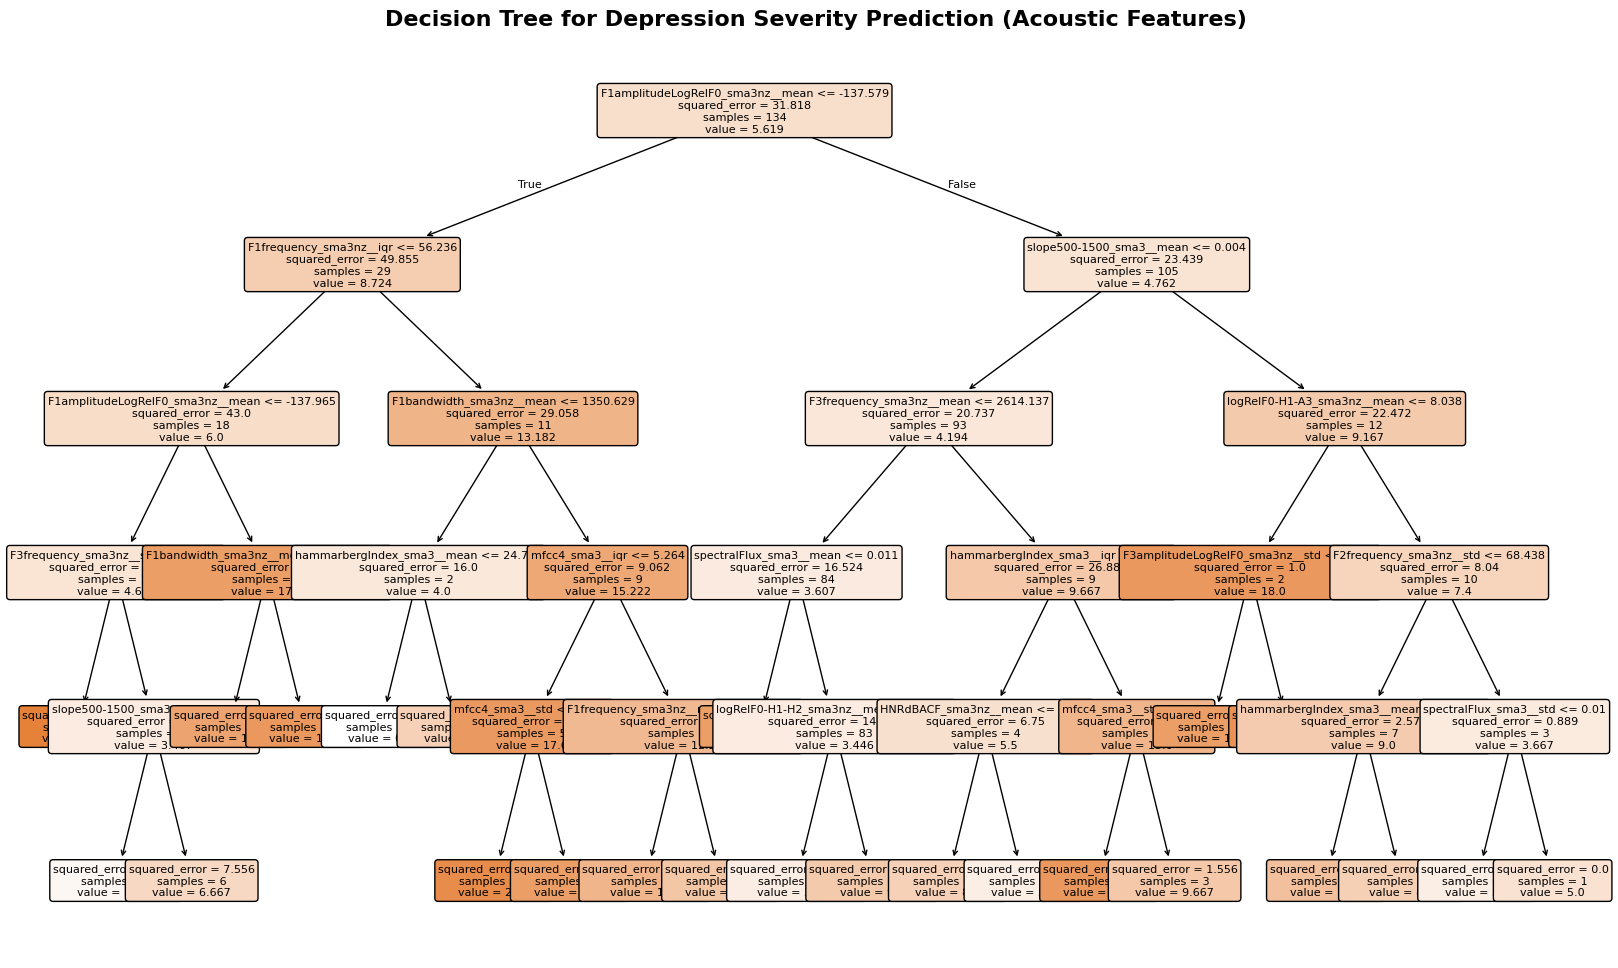

In [11]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Prepare the data
feature_columns = [col for col in acoustic_data_for_analysis.columns
                  if col not in ['ParticipantID', 'PHQ_Score']]

X = acoustic_data_for_analysis[feature_columns]
y = acoustic_data_for_analysis['PHQ_Score']

# Train the decision tree with optimal depth from your results
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X, y)

# Plot the tree
plt.figure(figsize=(20, 12))
plot_tree(
    dt,
    feature_names=feature_columns,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree for Depression Severity Prediction (Acoustic Features)",
          fontsize=16, fontweight='bold')
plt.show()

In [12]:
# Additional analysis: Check if specific feature types are more predictive
print("Analyzing feature categories")
feature_columns = [col for col in acoustic_data_for_analysis.columns
                  if col not in ['ParticipantID', 'PHQ_Score']]

# Categorize features by type
f0_features = [f for f in feature_columns if 'f0' in f.lower()]
formant_features = [f for f in feature_columns if any(x in f.lower() for x in ['f1', 'f2', 'f3'])]
voice_quality_features = [f for f in feature_columns if any(x in f.lower() for x in ['jitter', 'shimmer', 'hnr'])]
spectral_features = [f for f in feature_columns if any(x in f.lower() for x in ['slope', 'spectral'])]

print(f"F0 (pitch) features: {len(f0_features)}")
print(f"Formant features: {len(formant_features)}")
print(f"Voice quality features: {len(voice_quality_features)}")
print(f"Spectral features: {len(spectral_features)}")
print(f"Other features: {len(feature_columns) - len(f0_features) - len(formant_features) - len(voice_quality_features) - len(spectral_features)}")

Analyzing feature categories
F0 (pitch) features: 18
Formant features: 21
Voice quality features: 9
Spectral features: 9
Other features: 12


### (d) (2 points) Estimating depression severity with unimodal and multimodal deep learning models.

Question: In semantic feature extraction above, there are four features generated: neg, neu, pos, compound. They are inter-related because neg is the proportion of the document that is negative, neu is the proportion of the document that is neutral, pos is the proportion of the document that is positive, and compound is a normalized sentiment value that takes into account all 3. Should we remove some of these features because they're redundant?

### (e) (2 points) Explainable ML.

### (f) (Bonus, 2 points) Experimenting with transformers.